<h1>Data Preprocessing</h1>

In [48]:
import tensorflow as tf
from keras import models,layers
import matplotlib.pyplot as plt


In [49]:
IMG_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [50]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "../potato-disease",
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [51]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [52]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [53]:
train_ds=dataset.take(54)

In [54]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [55]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [56]:
val_ds=test_ds.take(6)
test_ds=test_ds.skip(6)
print(len(val_ds))
print(len(test_ds))

6
8


In [57]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffleSize=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffleSize,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [58]:
train_ds,val_ds,test_ds=get_dataset_partitions(dataset)

In [59]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [60]:
resize_and_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [61]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [62]:
input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [63]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [64]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [65]:
history=model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 111s 2s/step - loss: 0.7954 - accuracy: 0.5874 - val_loss: 0.6690 - val_accuracy: 0.7812
Epoch 2/50
54/54 [==============================] - 104s 2s/step - loss: 0.4549 - accuracy: 0.8287 - val_loss: 0.5683 - val_accuracy: 0.7865
Epoch 3/50
54/54 [==============================] - 105s 2s/step - loss: 0.3668 - accuracy: 0.8547 - val_loss: 0.2857 - val_accuracy: 0.8854
Epoch 4/50
54/54 [==============================] - 103s 2s/step - loss: 0.2548 - accuracy: 0.8987 - val_loss: 0.2432 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 103s 2s/step - loss: 0.2654 - accuracy: 0.8941 - val_loss: 0.1754 - val_accuracy: 0.9531
Epoch 6/50
54/54 [==============================] - 103s 2s/step - loss: 0.1855 - accuracy: 0.9311 - val_loss: 0.2967 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 103s 2s/step - loss: 0.1708 - accuracy: 0.9404 - val_loss: 0.2068 - val_accuracy: 0.9115
Epoch 8/50
54

In [66]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 3s 267ms/step - loss: 0.1056 - accuracy: 0.9688


In [67]:
scores

[0.1055501401424408, 0.96875]

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 258ms/step
predicted label: Potato___Early_blight


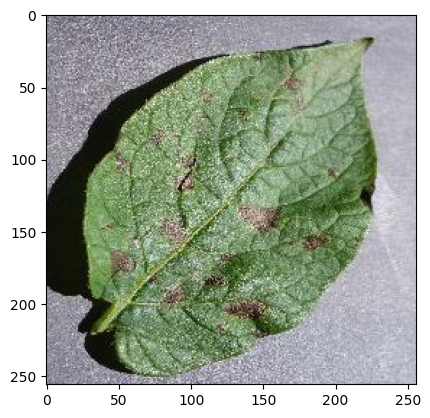

In [74]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [75]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


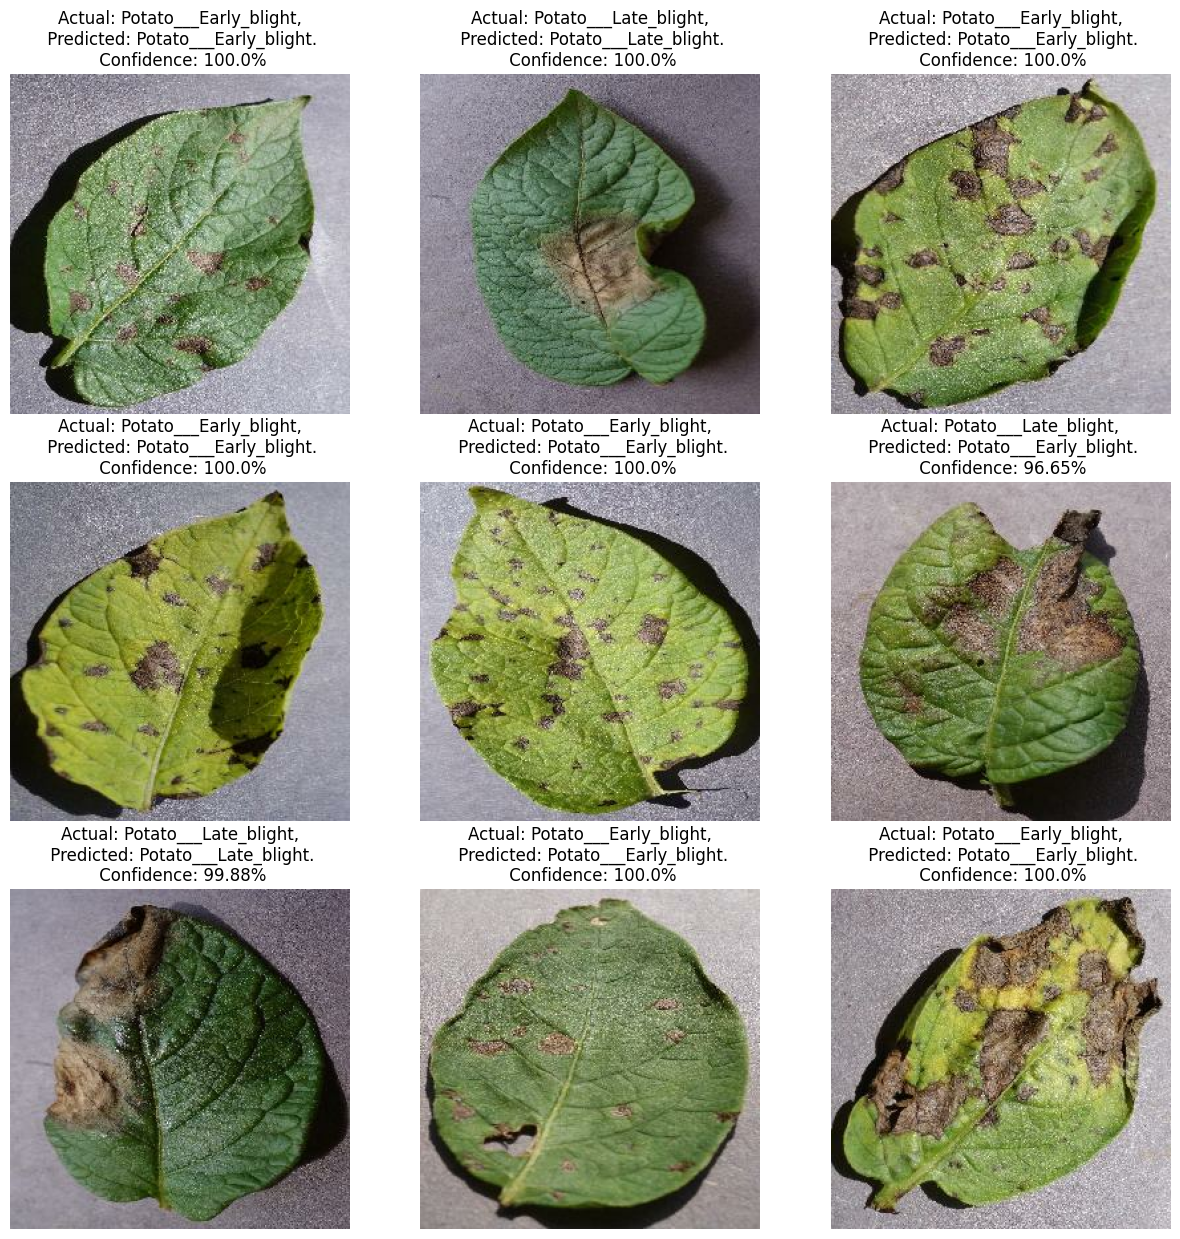

In [76]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [81]:
#save model
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets


: 

In [2]:
import tensorflow as tf

# Path to the directory where the model is saved
model_path = '../saved_models/1'

# Load the model
model = tf.keras.models.load_model(model_path)

# Print model summary to verify it's loaded correctly
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [3]:
model.save("../potato-model.h5")

c:\Users\sbhow\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
